In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(6)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.56:37559 Dashboard: http://10.148.1.56:8787/status,Cluster Workers: 12 Cores: 48 Memory: 600.00 GB


---


# 1. LLC results

In [6]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
E = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
print(E)
df=E.freq_time[1]-E.freq_time[0]
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
f_cpd = f*86400/2./np.pi

<xarray.DataArray (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(60, 720)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 -11.99 -11.98 -11.96 -11.94 -11.93 -11.91 ...


_________
# 2. Drifter Results

In [7]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
E_drifter = ds_linear_window.E_drifter_linear_window
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi

## LLC/Drifter

In [ ]:
E_ratio = xr.open_zarr(data_dir+'E_ratio.zarr').chunk({'freq_time': 1439, 'lat': 1}) 

_________
# 3. Global mean

In [8]:
# LLC4320 results
llc_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
ds_llc_cycl = xr.open_zarr(llc_dir+'E_cycl_all_openocean.zarr')
ds_llc_anti = xr.open_zarr(llc_dir+'E_anti_all_openocean.zarr')

E_llc_cycl = ds_llc_cycl.E_cycl_all
E_llc_anti = ds_llc_anti.E_anti_all

In [9]:
# Drifter - drogued
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_globalmean.zarr')
E_drifter_anti_qd = ds.E_drifter_anti
E_drifter_cycl_qd = ds.E_drifter_cycl

In [10]:
# Drifter - undrogued
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qu_globalmean.zarr')
E_drifter_anti_qu = ds.E_drifter_anti
E_drifter_cycl_qu = ds.E_drifter_cycl

In [11]:
# Drifter - drogued & GPS-tracked
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_globalmean_GPS.zarr')
E_drifter_anti_qd_GPS = ds.E_drifter_anti
E_drifter_cycl_qd_GPS = ds.E_drifter_cycl

In [12]:
# make freq negative

E_llc_anti = E_llc_anti.assign_coords(freq_time=E_llc_anti.freq_time * -1.) 
E_drifter_anti_qd = E_drifter_anti_qd.assign_coords(freq_time=E_drifter_anti_qd.freq_time * -1.) 
E_drifter_anti_qu = E_drifter_anti_qu.assign_coords(freq_time=E_drifter_anti_qu.freq_time * -1.) 
E_drifter_anti_qd_GPS = E_drifter_anti_qd_GPS.assign_coords(freq_time=E_drifter_anti_qd_GPS.freq_time * -1.) 

# 4. Figure together

In [13]:
# tidal frequencies
ptidal_frequency = [0.825518, 0.856952, 0.861809, 0.893244, 0.898101, 0.929536, 0.935012, 0.96097, 0.966446, 0.971303, 0.994524, 0.997262, 1, 1.00274, 1.00548, 1.00821, 1.03417, 1.03903, 1.06499, 1.07046, 1.07594, 1.11223, 1.76053, 1.79196, 1.79682, 1.79744, 1.8234, 1.82826, 1.83373, 1.8536, 1.85907, 1.85969, 1.86455, 1.89051,1.89598,
1.90084,1.90693,1.9268,1.92742,1.92954,1.93227,1.93501,1.93775,1.94323,1.95823,1.96371,1.96857,1.99452,1.99726,2,2.00274,2.00548,2.03629,2.04177,2.04724,2.06773,2.07258,2.0732,2.10402,2.82552,2.86181,2.89841,2.89872,2.92954,2.93501,2.99726,3.00274,
3.76053,3.79196,3.79682,3.82278,3.82826,3.83373,3.85907,3.86455,3.87002,3.89598,3.90146,3.93227,3.93775,3.96857,4,4.00548,4.75779,4.79408,4.79956,4.83099,4.86181,4.86729,4.93501,4.94049,5.00274,5.69342,5.72424,5.72971,5.76053,5.76601,5.79135,5.79682,
5.82826,5.83373,5.85907,5.86455,5.87002,5.90146,5.93227,5.93775,6,6.69006,6.72698,6.76296,6.79408,6.79956,6.86729,7.65651,7.6928,7.69828,7.72909,7.76053,7.76601,7.79682,7.8023,7.83373,7.86455,7.87002,8.65925,8.69554,8.73183,8.79956,9.62508,9.66137,
9.6928,9.72909,9.76601,9.79682,10.7318,11.5936,11.6614,11.6983]

In [14]:
ntidal_frequency = [ -x for x in ptidal_frequency]

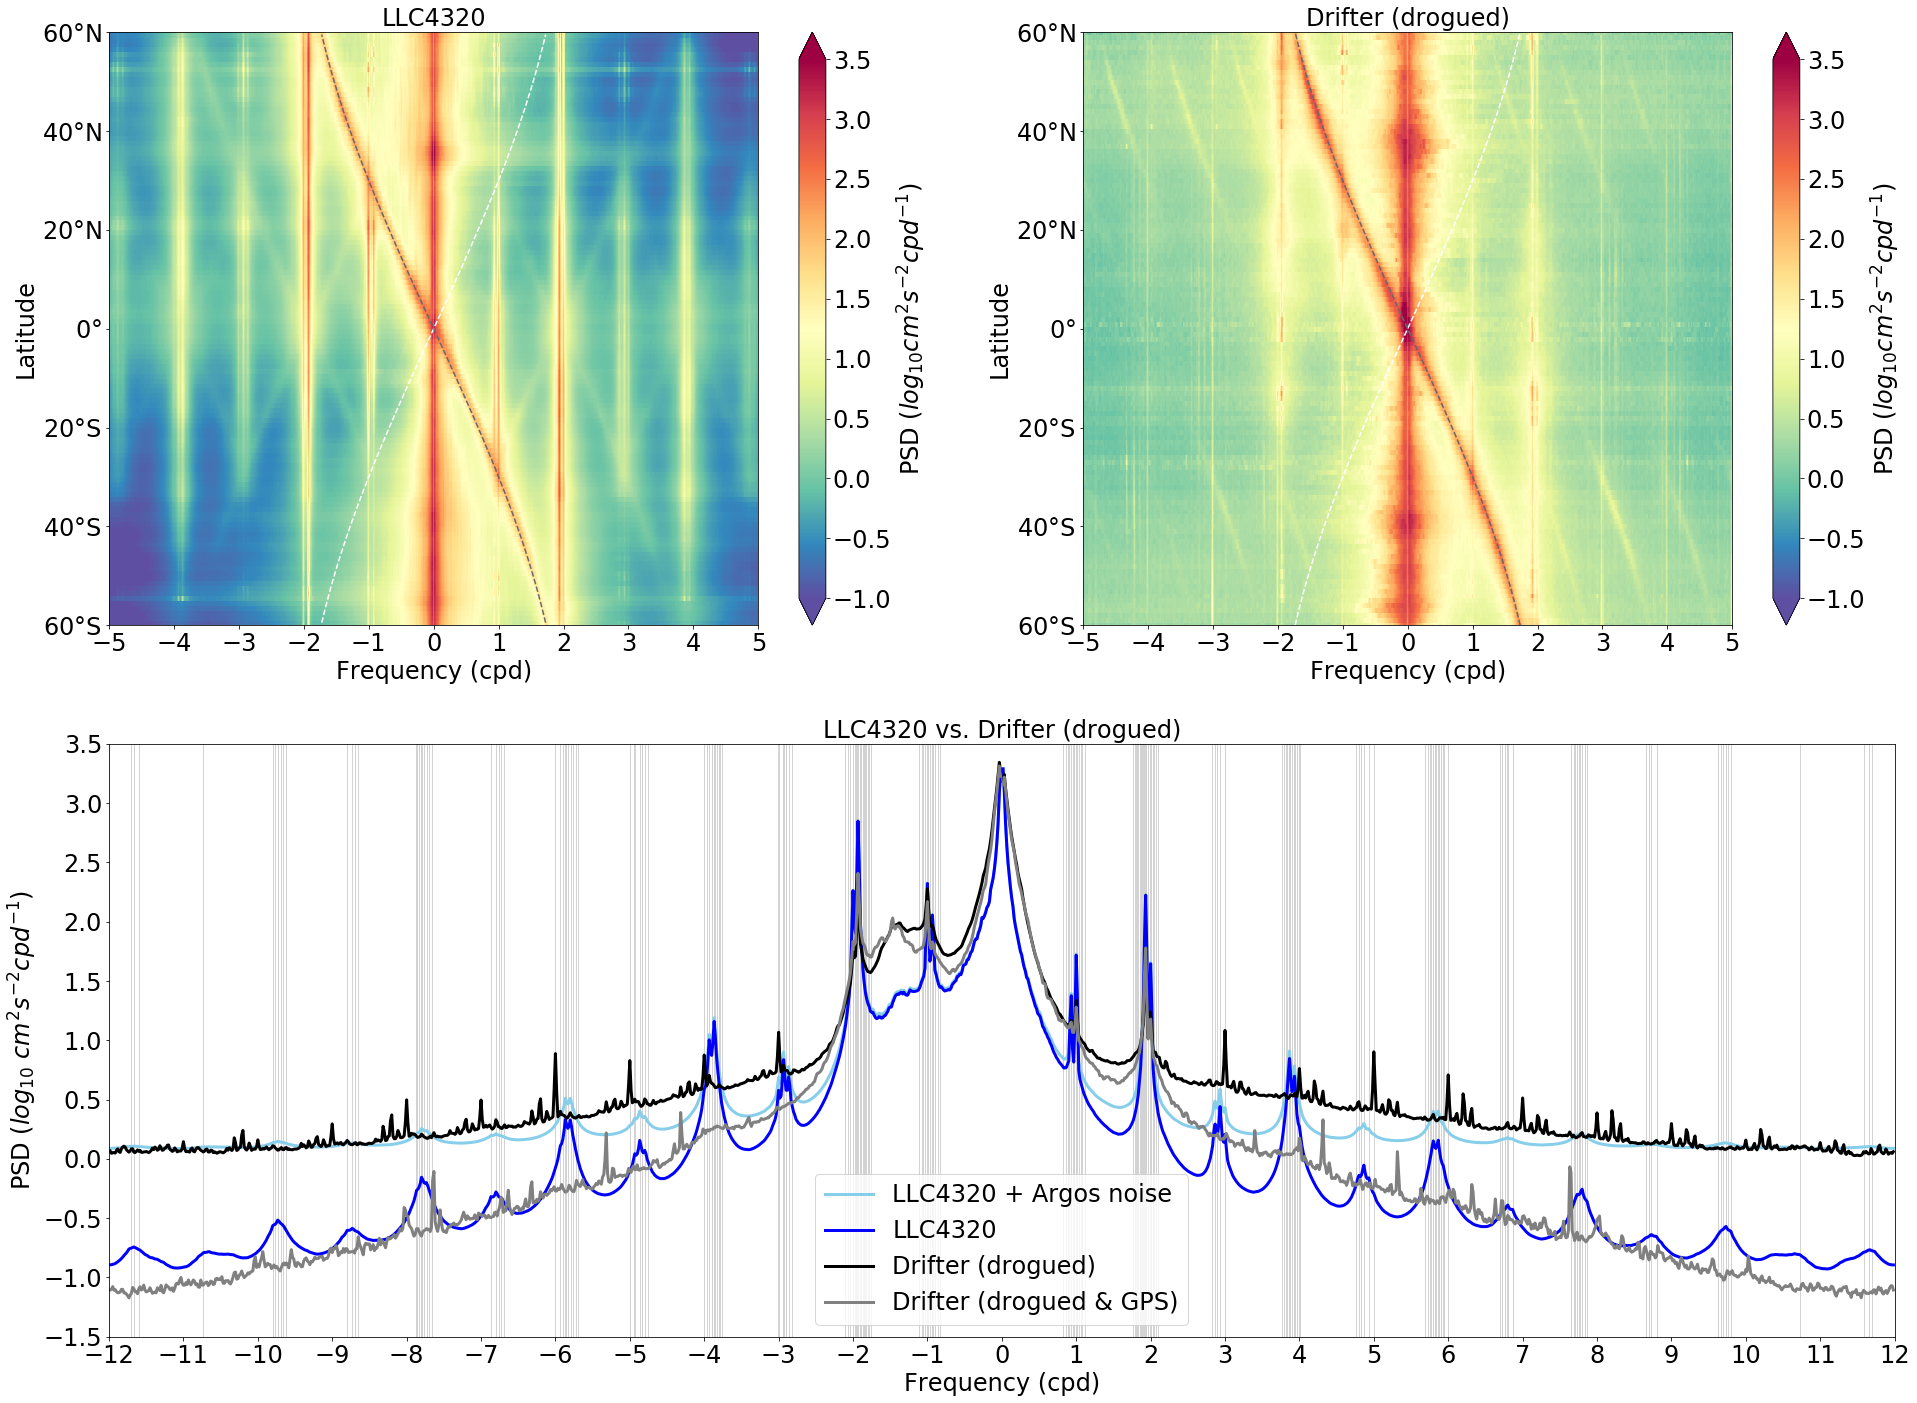

In [76]:
font_size = 24

fig, ax = plt.subplots(figsize=(32,24))


# LLC4320
ax = plt.subplot(2,2,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'w--')
ax.plot(-f*86400./2./np.pi,f.lat,'--',color='dimgrey')
ax.set_title('LLC4320',fontsize=font_size)


# Drifters
ax = plt.subplot(2,2,2)
cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('Drifter (drogued)',fontsize=font_size)


# Global averaged
ax = plt.subplot(2,2,(3,4))
labels = ['LLC4320','LLC4320 + Argos noise', 'Drifter (drogued)','', 'Drifter (drogued & GPS)']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
# llc + noise
np.log10(E_llc_anti+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[1], linewidth=3)
np.log10(E_llc_cycl+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[3], linewidth=3)
# llc
np.log10(E_llc_anti).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
np.log10(E_llc_cycl).plot(ax=ax,color='blue', label=labels[3], linewidth=3)
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[3])
# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[4])
np.log10(E_drifter_anti_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])
ax.legend(); 
#ax.grid()
ax.set_ylim([-1.5,3.5])
ax.set_yticks([-1.5,-1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': font_size},loc='lower center')
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 vs. Drifter (drogued)',fontsize=font_size)


plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifter_comparison_22.png')


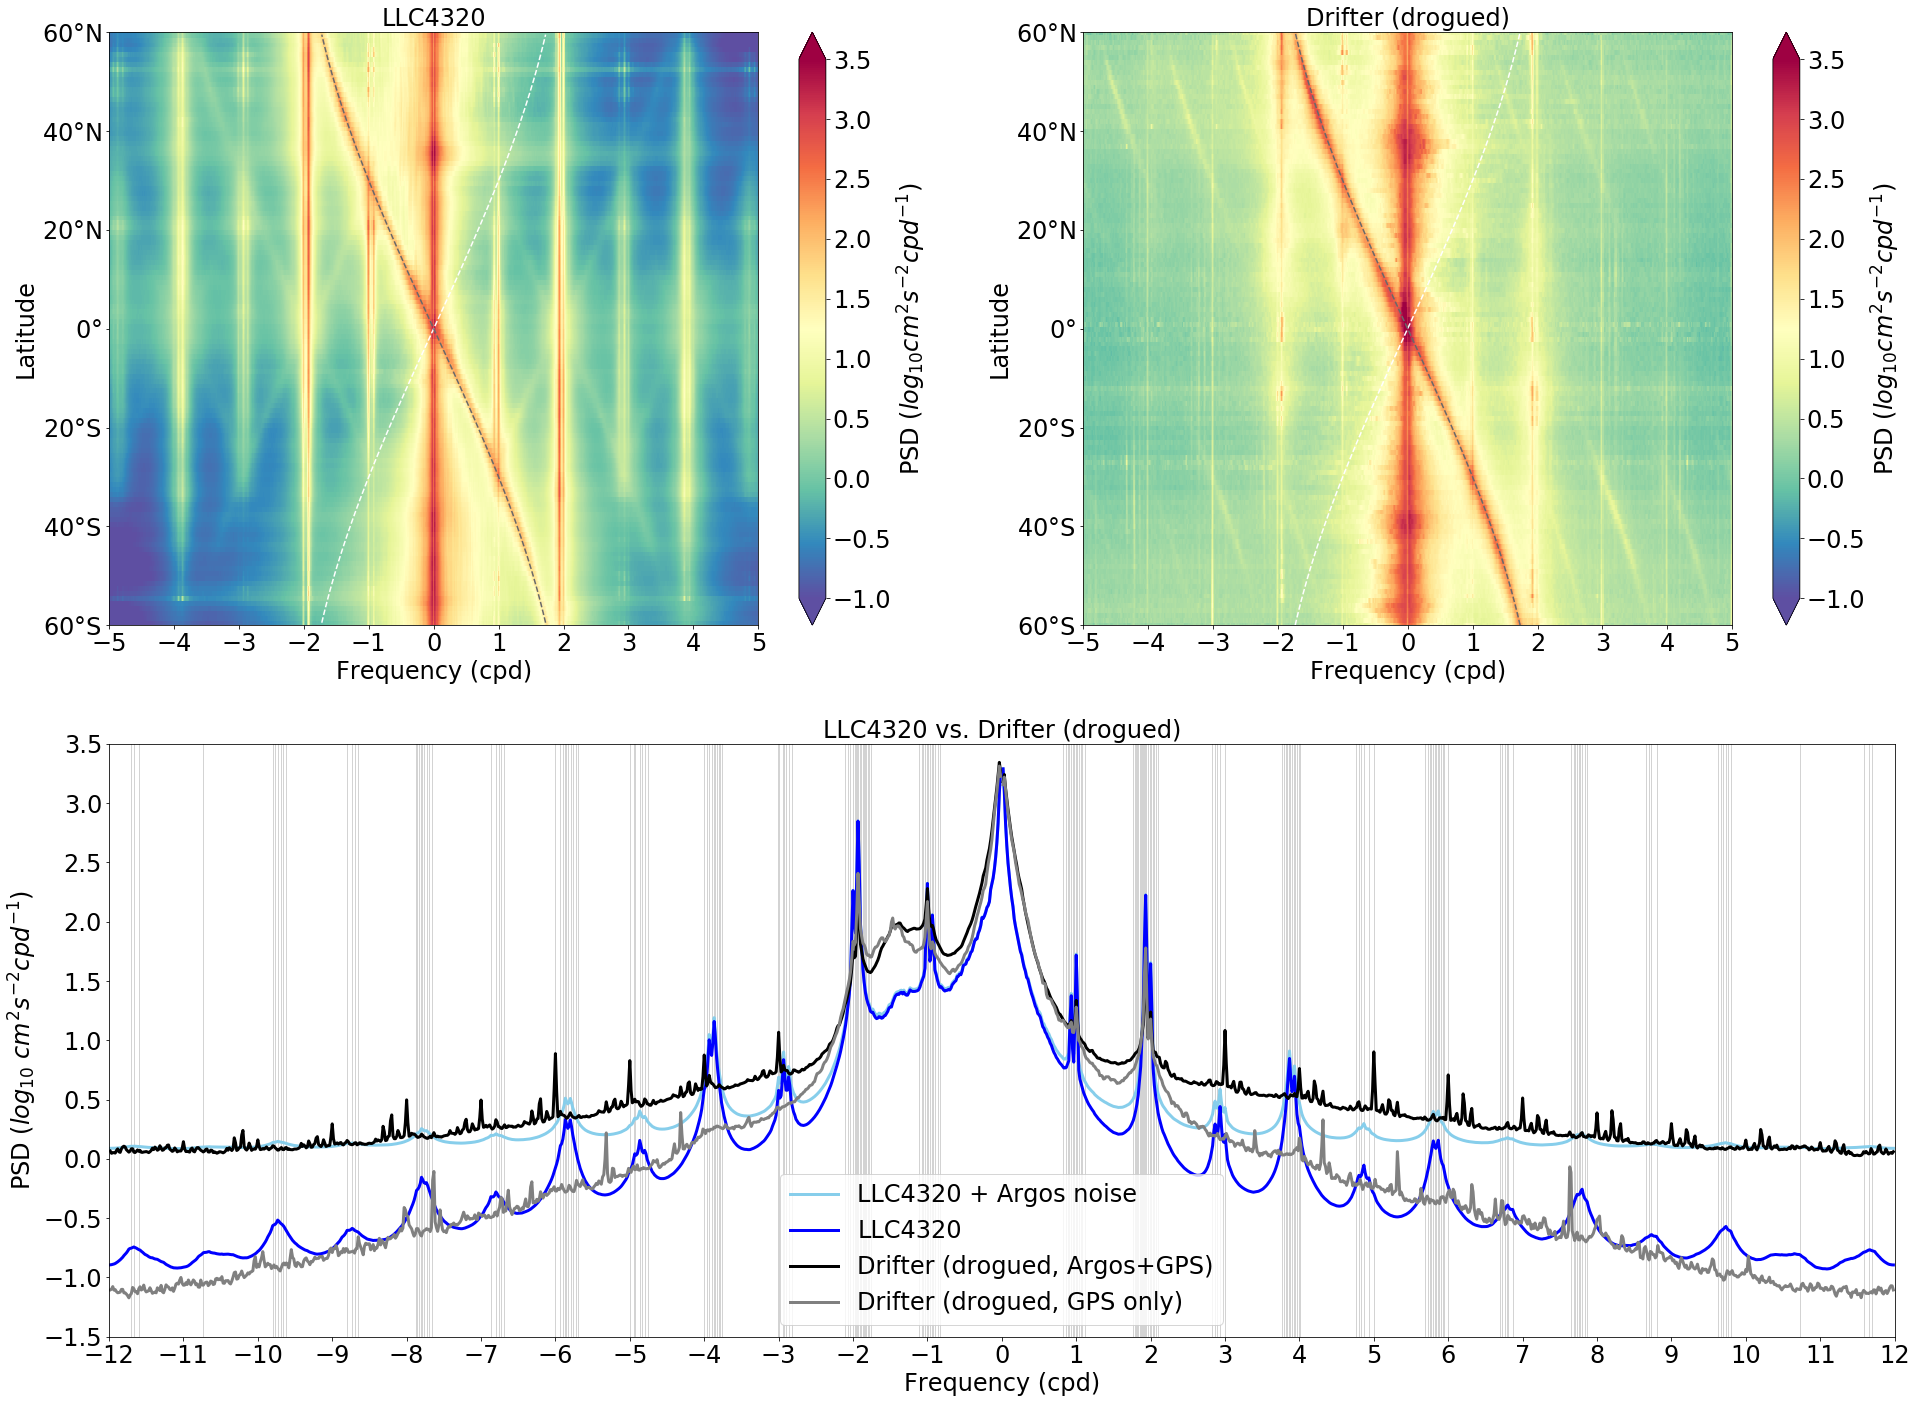

In [16]:
font_size = 24

fig, ax = plt.subplots(figsize=(32,24))


# LLC4320
ax = plt.subplot(2,2,1)
E = E.assign_coords(freq_cpd=E.freq_time * 86400.) 
cax = np.log10(E/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E.lat))
ax.plot(f*86400./2./np.pi,f.lat,'w--')
ax.plot(-f*86400./2./np.pi,f.lat,'--',color='dimgrey')
ax.set_title('LLC4320',fontsize=font_size)


# Drifters
ax = plt.subplot(2,2,2)
cax = np.log10(E_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('Drifter (drogued)',fontsize=font_size)


# Global averaged
ax = plt.subplot(2,2,(3,4))
labels = ['LLC4320','LLC4320 + Argos noise', 'Drifter (drogued, Argos+GPS)','', 'Drifter (drogued, GPS only)']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
# llc + noise
np.log10(E_llc_anti+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[1], linewidth=3)
np.log10(E_llc_cycl+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[3], linewidth=3)
# llc
np.log10(E_llc_anti).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
np.log10(E_llc_cycl).plot(ax=ax,color='blue', label=labels[3], linewidth=3)
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[3])
# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[4])
np.log10(E_drifter_anti_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])
ax.legend(); 
#ax.grid()
ax.set_ylim([-1.5,3.5])
ax.set_yticks([-1.5,-1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': font_size},loc='lower center')
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('LLC4320 vs. Drifter (drogued)',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifter_comparison_22.png')


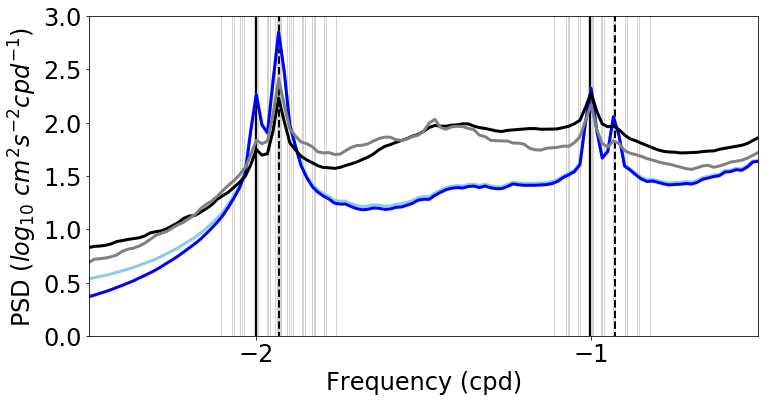

In [72]:
font_size = 24

fig, ax = plt.subplots(figsize=(12,20))


# Global averaged
ax = plt.subplot(3,2,(3,4))
labels = ['LLC4320','LLC4320 + Argos noise', 'Drifter (drogued)','', 'Drifter (drogued & GPS)']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 

ax.plot([-0.929536,-0.929536],[-2,4], 'k--', linewidth=2)        # O1
ax.plot([-1.00274,-1.00274],[-2,4], linewidth=2, color='black')  # K1

#ax.plot([-2.00548,-2.00548],[-2,4], linewidth=2, color='black')  # k2
ax.plot([-2.00,-2.00],[-2,4], linewidth=2, color='black')  # S2
ax.plot([-1.93227,-1.93227],[-2,4], 'k--',linewidth=2)           # M2



# llc + noise
np.log10(E_llc_anti+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[1], linewidth=3)
np.log10(E_llc_cycl+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[3], linewidth=3)
# llc
np.log10(E_llc_anti).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
np.log10(E_llc_cycl).plot(ax=ax,color='blue', label=labels[3], linewidth=3)
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[3])
# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[4])
np.log10(E_drifter_anti_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])
ax.set_ylim([0,3])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5,3.])
ax.set_xlim([-2.5,-0.5])
ax.set_xticks([-2, -1])
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifter_comparison_zoomin_anti.png')


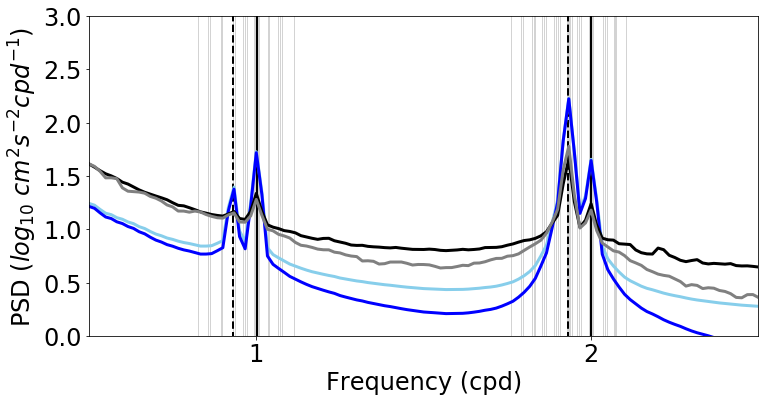

In [73]:
font_size = 24

fig, ax = plt.subplots(figsize=(12,20))


# Global averaged
ax = plt.subplot(3,2,(3,4))
labels = ['LLC4320','LLC4320 + Argos noise', 'Drifter (drogued)','', 'Drifter (drogued & GPS)']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 

ax.plot([0.929536,0.929536],[-2,4], 'k--', linewidth=2)        # O1
ax.plot([1.00274,1.00274],[-2,4], linewidth=2, color='black')  # K1

#ax.plot([-2.00548,-2.00548],[-2,4], linewidth=2, color='black')  # k2
ax.plot([2.00,2.00],[-2,4], linewidth=2, color='black')  # S2
ax.plot([1.93227,1.93227],[-2,4], 'k--',linewidth=2)           # M2


# llc + noise
np.log10(E_llc_anti+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[1], linewidth=3)
np.log10(E_llc_cycl+1.1).plot(ax=ax,linestyle='-',color='skyblue', label=labels[3], linewidth=3)
# llc
np.log10(E_llc_anti).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
np.log10(E_llc_cycl).plot(ax=ax,color='blue', label=labels[3], linewidth=3)
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[3])
# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[4])
np.log10(E_drifter_anti_qd_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])
ax.set_ylim([0,3])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5,3.])
ax.set_xlim([0.5,2.5])
ax.set_xticks([1,2])
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_LLC_drifter_comparison_zoomin_cycl.png')


## Figure S2

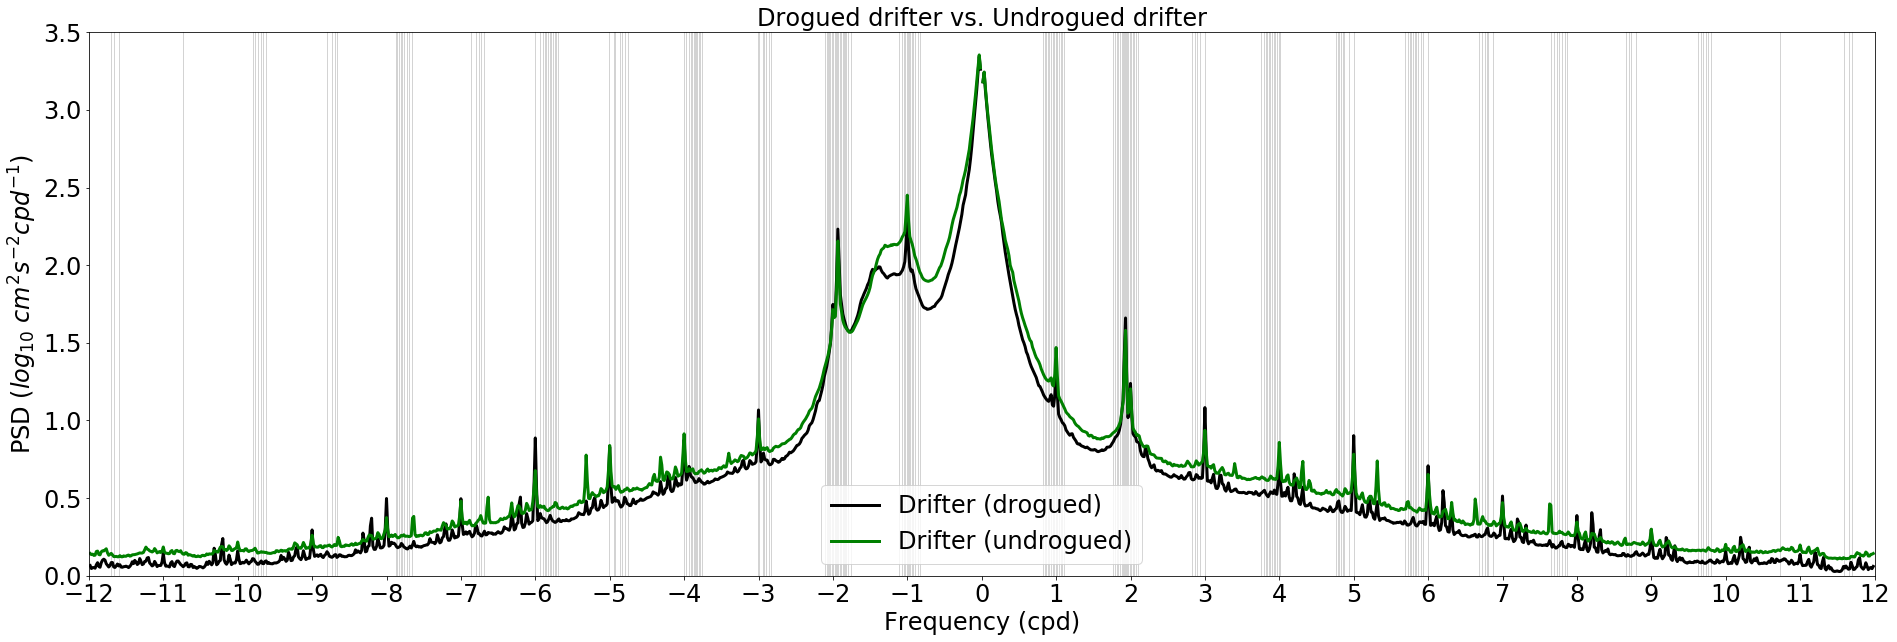

In [29]:
font_size = 24

fig, ax = plt.subplots(figsize=(32,10))


# Global averaged
ax = plt.subplot(1,1,1)
labels = ['Drifter (drogued)', 'Drifter (undrogued)','']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[0])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qu).plot(ax=ax, linewidth=3, color='green', label=labels[1])
np.log10(E_drifter_anti_qu).plot(ax=ax, linewidth=3, color='green', label=labels[2])
#ax.grid()
ax.set_ylim([0,3.5])
ax.set_yticks([0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': font_size},loc="upper right")
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Drogued drifter vs. Undrogued drifter',fontsize=font_size)
ax.legend(prop={'size': font_size},loc='lower center')

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_drifter_comparison_FigureS2.png')


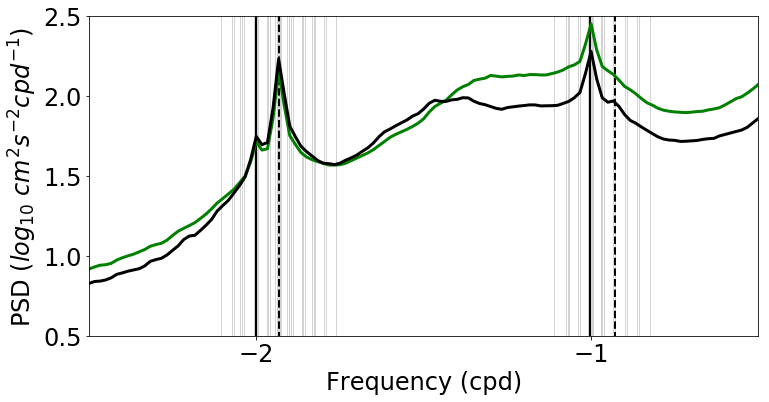

In [26]:
font_size = 24

fig, ax = plt.subplots(figsize=(12,20))


# Global averaged
ax = plt.subplot(3,2,(3,4))
labels = ['Drifter (drogued)', 'Drifter (undrogued)','']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 

ax.plot([-0.929536,-0.929536],[-2,4], 'k--', linewidth=2)        # O1
ax.plot([-1.00274,-1.00274],[-2,4], linewidth=2, color='black')  # K1
ax.plot([-2.00,-2.00],[-2,4], linewidth=2, color='black')  # S2
ax.plot([-1.93227,-1.93227],[-2,4], 'k--',linewidth=2)           # M2


# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qu).plot(ax=ax, linewidth=3, color='green', label=labels[1])
np.log10(E_drifter_anti_qu).plot(ax=ax, linewidth=3, color='green', label=labels[2])
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[0])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
ax.set_ylim([0.5,2.5])
ax.set_yticks([0.5, 1., 1.5, 2., 2.5])
ax.set_xlim([-2.5,-0.5])
ax.set_xticks([-2, -1])
#ax.legend(prop={'size': font_size},loc="upper right")
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_drifter_comparison_inset1.png')


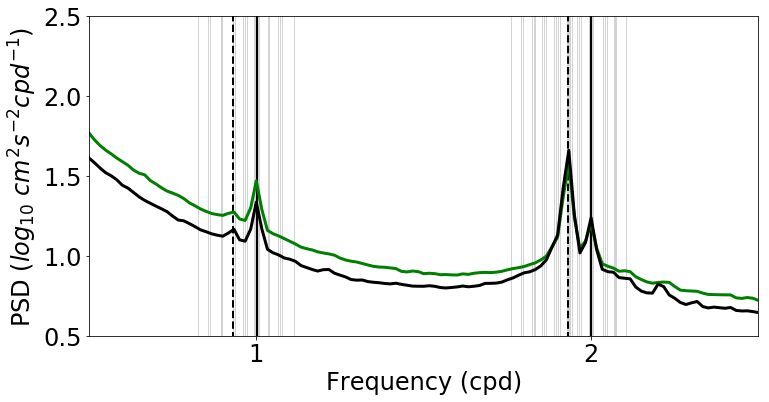

In [27]:
font_size = 24

fig, ax = plt.subplots(figsize=(12,20))


# Global averaged
ax = plt.subplot(3,2,(3,4))
labels = ['Drifter (drogued)', 'Drifter (undrogued)','']
# tidal frequencies - vertical lightgrey lines
ax.plot([ptidal_frequency,ptidal_frequency],[-2,4], linewidth=1, color='lightgrey') 
ax.plot([ntidal_frequency,ntidal_frequency],[-2,4], linewidth=1, color='lightgrey') 

ax.plot([0.929536,0.929536],[-2,4], 'k--', linewidth=2)        # O1
ax.plot([1.00274,1.00274],[-2,4], linewidth=2, color='black')  # K1
ax.plot([2.00,2.00],[-2,4], linewidth=2, color='black')  # S2
ax.plot([1.93227,1.93227],[-2,4], 'k--',linewidth=2)           # M2


# drifter (drogued & GPS)
np.log10(E_drifter_cycl_qu).plot(ax=ax, linewidth=3, color='green', label=labels[1])
np.log10(E_drifter_anti_qu).plot(ax=ax, linewidth=3, color='green', label=labels[2])
# drifter (drogued)
np.log10(E_drifter_cycl_qd).plot(ax=ax, linewidth=3, color='black', label=labels[0])
np.log10(E_drifter_anti_qd).plot(ax=ax, linewidth=3, color='black', label=labels[2])
ax.set_ylim([0.5,2.5])
ax.set_yticks([0.5, 1., 1.5, 2., 2.5])
ax.set_xlim([0.5,2.5])
ax.set_xticks([1,2])
#ax.legend(prop={'size': font_size},loc="upper right")
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_drifter_comparison_inset2.png')


In [18]:
cluster.scheduler.close()

<Future finished result=None>